# Melbourne Housing Snapshot

Melbourne Housing Predictions and Feature Engineering

## References

- https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot

# Initialization

In [1]:
RANDOM_SEED = 42 #@param {type: 'integer'}

## Imports

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_SEED)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from math import ceil
from multiprocessing import cpu_count

## Load the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pip install kaggle -q
%cp "/content/drive/MyDrive/Colab Notebooks/Kaggle/jofaval-kaggle.json" "kaggle.json"
%mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d dansbecker/melbourne-housing-snapshot
!unzip -o melbourne-housing-snapshot.zip

  0% 0.00/451k [00:00<?, ?B/s]
100% 451k/451k [00:00<00:00, 81.2MB/s]
Archive:  melbourne-housing-snapshot.zip
  inflating: melb_data.csv           


In [6]:
dataframe = pd.read_csv('melb_data.csv')
dataframe.shape

(13580, 21)

# Data cleaning and preprocesing

From this stage forward, the data should be quality and clean data

In [7]:
dataframe.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0


## Backup

Just in case

In [8]:
df = dataframe.copy(deep=True)

## Missing values

We know for a fact that this dataset has null values, let's see how it is distributed

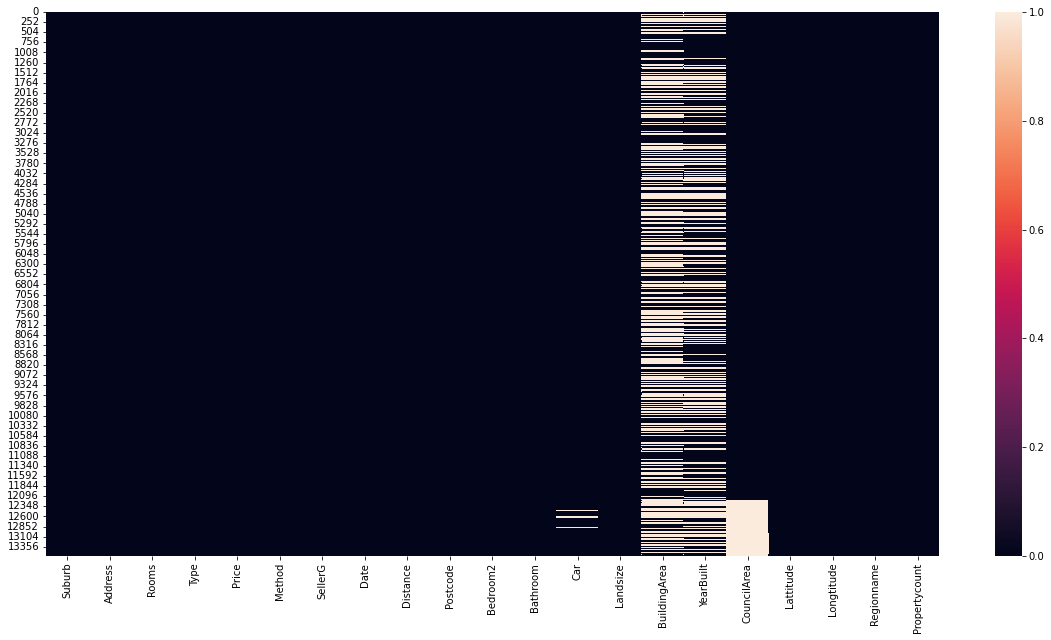

In [9]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isna(), cbar=True)

We can handle car right now

In [10]:
df['Car'] = df['Car'].fillna(df['Car'].mode()[0])

As for the Year built, we'll get the year it was pruchased at, not the best scenario, but at least it can give us an idea.

It could be filled with the mean between the date a house was bought and the year it was built in substracted to the date it was currently bought in. But that'd be overcomplicating without certainty:

```python
year_built = current_date.year() - (date.year() - year_built).mean()
```

In [11]:
def fill_year_built(x: pd.Series) -> pd.Series:
  row = x.copy(deep=True)

  if row['YearBuilt'] != float(row['YearBuilt']):
    row['YearBuilt'] = float(row['Date'].split('/')[-1])

  return row

df = df.apply(fill_year_built, axis=1)

And the building area will be filled with the mode, simply because it's an integer column as a float one, using the mean won't be as useful here

In [12]:
df['BuildingArea'] = df['BuildingArea'].fillna(df['BuildingArea'].mode()[0])

## Transformation

Making sure all the values are numeric and as clearly understandable for the model as possible. I'll be doing a little bit of feature engineering as to help me with the process

Let us first visualize the columns we're trying to transform

In [13]:
df.select_dtypes(include=object).columns

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname'],
      dtype='object')

### Suburb

In [14]:
len(df['Suburb'].unique())

314

In [15]:
df['Suburb'] = pd.factorize(df['Suburb'])[0]

### Address

This is where some sort of feature engineering will be applied

In [16]:
df['Address'].head(5)

0        85 Turner St
1     25 Bloomburg St
2        5 Charles St
3    40 Federation La
4         55a Park St
Name: Address, dtype: object

The address number

In [17]:
df['AddressNumber'] = df['Address'].map(lambda x: x.split(' ')[0])

And from the address number we can extract what I suppose is the door number, maybe

In [18]:
df['AddressDoor'] = df['AddressNumber'].map(lambda x: x.split('/')[-1] if '/' in x else np.NAN)

In [19]:
df['AddressDoor'] = pd.factorize(df['AddressDoor'])[0]
df['AddressNumber'] = pd.factorize(df['AddressNumber'])[0]

The address type

In [20]:
df['AddressType'] = df['Address'].map(lambda x: x.split(' ')[-1])
df['AddressType'] = pd.factorize(df['AddressType'])[0]

In [21]:
len(df['AddressType'].unique())

60

And finally the address name, which will be everything in between

In [22]:
df['AddressName'] = df['Address'].map(lambda x: ' '.join(x.split(' ')[1:-1]))
df['AddressName'] = pd.factorize(df['AddressName'])[0]

Once we've extract all the information that there is to the address, we should remove the original feature, as we'll no longer be needing it

In [23]:
df = df.drop(columns=['Address'])

### Type

In [24]:
df = pd.get_dummies(df, columns=['Type'])

### Method

In [25]:
df = pd.get_dummies(df, columns=['Method'])

### SellerG

In [26]:
len(df['SellerG'].unique())

268

In [27]:
df['SellerG'] = pd.factorize(df['SellerG'])[0]

### Date

This one will have a little bit of feature engineering, but mostly, date conversion using sin and cos

In [28]:
df['Date'].head(5)

0    3/12/2016
1    4/02/2016
2    4/03/2017
3    4/03/2017
4    4/06/2016
Name: Date, dtype: object

The new features from the date

In [29]:
df['YearSold'] = df['Date'].map(lambda x: int(x.split('/')[0]))
df['DaySold'] = df['Date'].map(lambda x: int(x.split('/')[-1]))

The date conversion to sin and cos so that, each day can now properly represent an exact and unique moment in the year

In [30]:
day = 24 * 60 * 60
year = day * 365.2425

date_time = pd.to_datetime(df.pop('Date'))
timestamp_s = date_time.map(pd.Timestamp.timestamp)

df['Date_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Date_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

### CouncilArea

In [31]:
len(df['CouncilArea'].unique())

34

In [32]:
df['CouncilArea'] = pd.factorize(df['CouncilArea'])[0]

### Regionname

In [33]:
len(df['Regionname'].unique())

8

In [34]:
df = pd.get_dummies(df, columns=['Regionname'])

### Once transformed

No non-numeric value should appear

In [35]:
df.select_dtypes(include=object).columns

Index([], dtype='object')

## Abnormal values

Any value out of the scope of what is supposed to be/take

In [36]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Suburb,13580.0,8.377283e+01,62.727719,0.000000,38.000000,76.000000,1.080000e+02,3.130000e+02
Rooms,13580.0,2.937997e+00,0.955748,1.000000,2.000000,3.000000,3.000000e+00,1.000000e+01
Price,13580.0,1.075684e+06,639310.724296,85000.000000,650000.000000,903000.000000,1.330000e+06,9.000000e+06
SellerG,13580.0,2.955692e+01,38.330760,0.000000,3.000000,18.000000,4.200000e+01,2.670000e+02
Distance,13580.0,1.013778e+01,5.868725,0.000000,6.100000,9.200000,1.300000e+01,4.810000e+01
Postcode,13580.0,3.105302e+03,90.676964,3000.000000,3044.000000,3084.000000,3.148000e+03,3.977000e+03
Bedroom2,13580.0,2.914728e+00,0.965921,0.000000,2.000000,3.000000,3.000000e+00,2.000000e+01
Bathroom,13580.0,1.534242e+00,0.691712,0.000000,1.000000,1.000000,2.000000e+00,8.000000e+00
Car,13580.0,1.611856e+00,0.960793,0.000000,1.000000,2.000000,2.000000e+00,1.000000e+01
Landsize,13580.0,5.584161e+02,3990.669241,0.000000,177.000000,440.000000,6.510000e+02,4.330140e+05


## Correlation

Let's see if there's values that may just be adding noise th our model

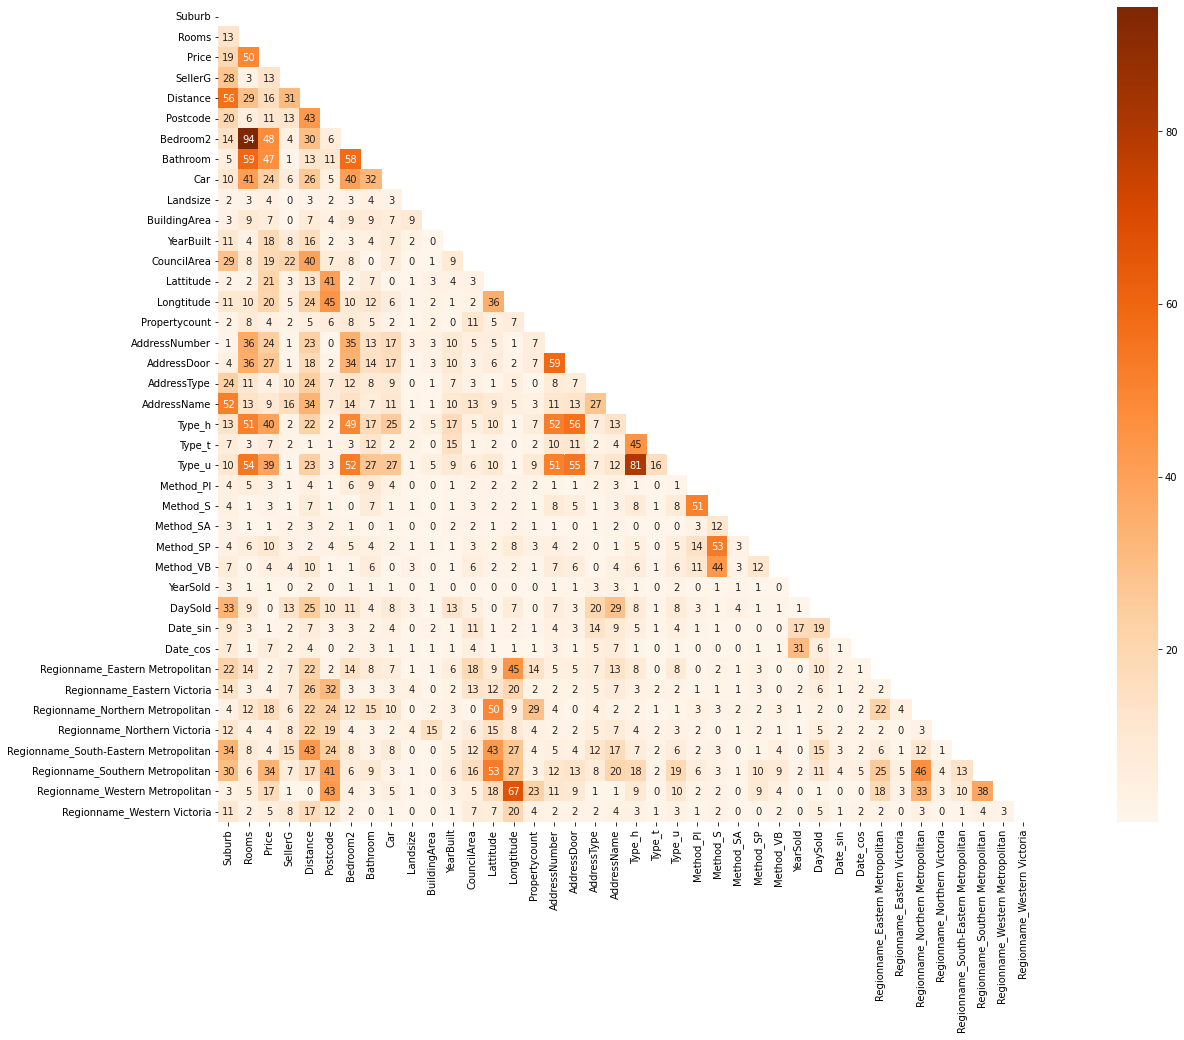

In [37]:
plt.figure(figsize=(30, 15))
correlation = df.corr().abs() * 100
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.0f', cmap='Oranges', square=True, mask=matrix, cbar=True, cbar_kws={'orientation': 'vertical'})

## Missing values, after the preprocesing

After cleaning everything up the missing values should be non-existent

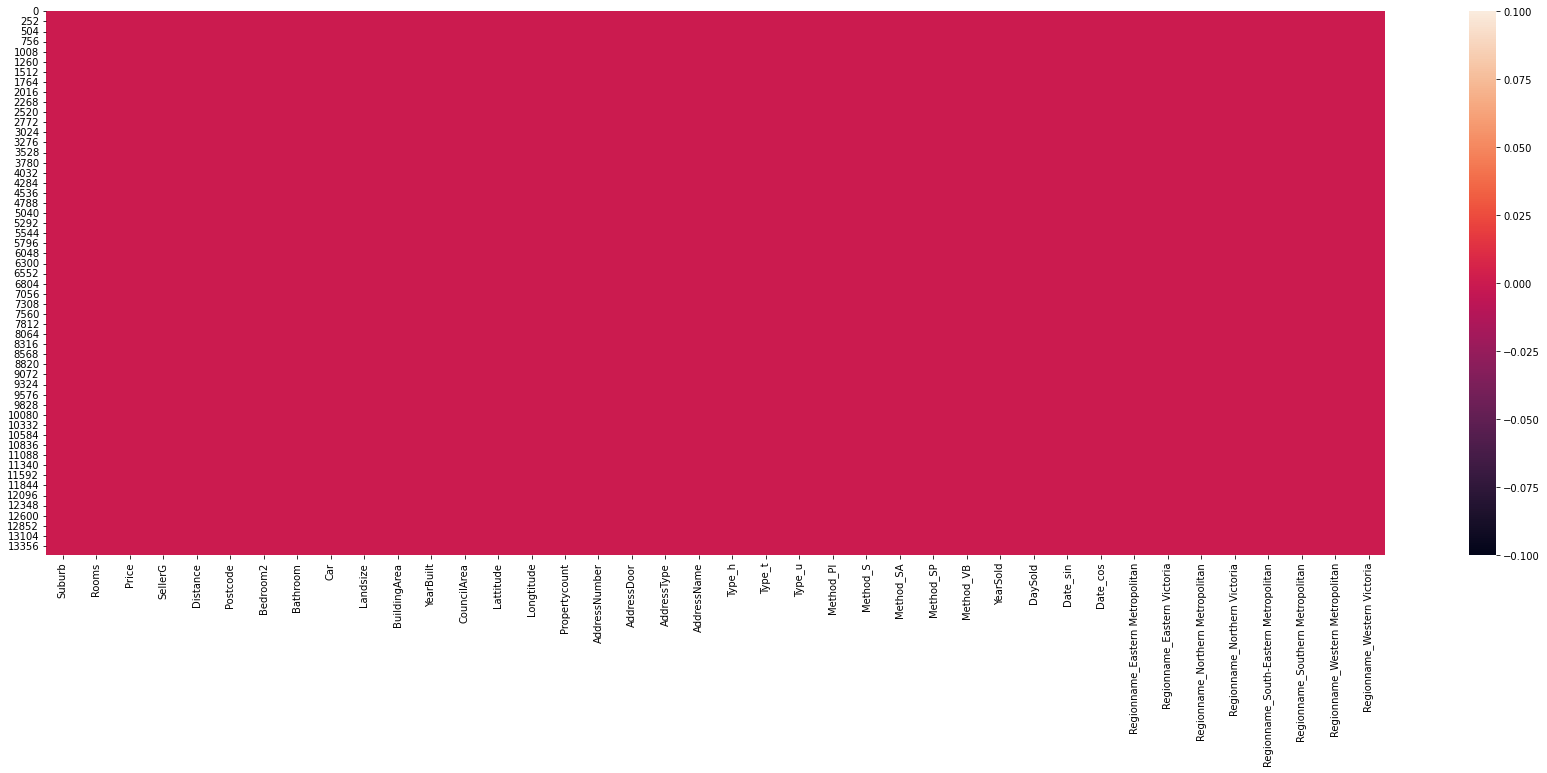

In [38]:
plt.figure(figsize=(30, 10))
sns.heatmap(df.isna(), cbar=True)

# Exploratory Data Analysis

Understanding the data, hypothesization, identifying patterns or abnormalies

## Data distribution

In [39]:
if False:
  columns = [ col for col in df.columns if col not in ['Price'] ]
  fig, axes = plt.subplots(1, len(columns), figsize=(len(columns) * 2.5, 10))
  axes.flatten()
  for index, col in enumerate(columns):
    sns.boxplot(data=df, y=col, ax=axes[index])
  plt.tight_layout(pad=1.5, w_pad=.5, h_pad=.5)

### Price distribution

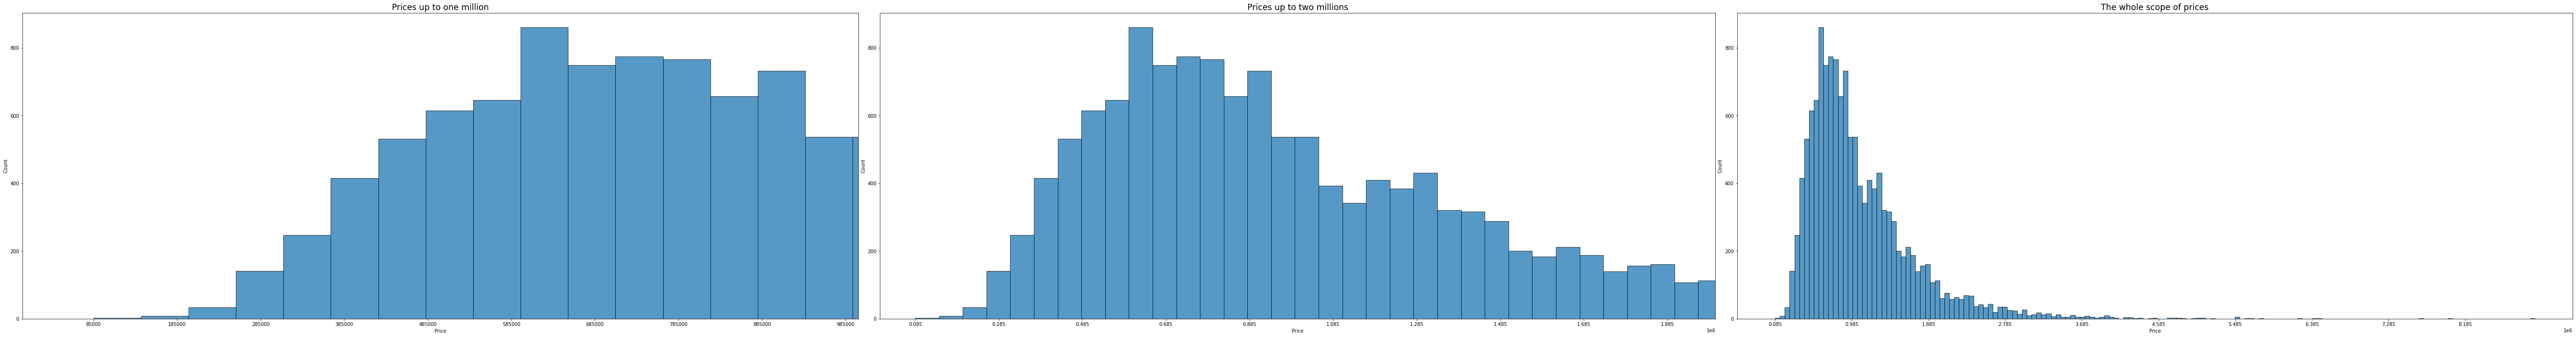

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(75, 10))
# fig.suptitle('Pricde distribution by ranges')

axes[0].set_xticks(range(ceil(df.Price.min()), 1_000_000, ceil(1_000_000 / 10)))
axes[0].set_title('Prices up to one million', fontsize='xx-large')
sns.histplot(data=df, x='Price', ax=axes[0])
axes[0].set_xlim(0, 1_000_000)

axes[1].set_xticks(range(ceil(df.Price.min()), 2_000_000, ceil(2_000_000 / 10)))
axes[1].set_title('Prices up to two millions', fontsize='xx-large')
sns.histplot(data=df, x='Price', ax=axes[1])
axes[1].set_xlim(0, 2_000_000)

axes[2].set_title('The whole scope of prices', fontsize='xx-large')
axes[2].set_xticks(range(ceil(df.Price.min()), ceil(df.Price.max()), ceil(df.Price.max() / 10)))
sns.histplot(data=df, x='Price', ax=axes[2])

plt.tight_layout(pad=1.5, h_pad=.5, w_pad=.5)

## Dependant explainability

In [41]:
if False:
  columns = [ col for col in df.columns if col not in ['Price'] ]
  n_cols = 4
  n_rows = ceil(len(columns) / n_cols)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7.5, n_rows * 5))
  axes.flatten()
  for index, col in enumerate(columns):
    sns.scatterplot(data=df, x=col, y='Price', ax=axes[index])

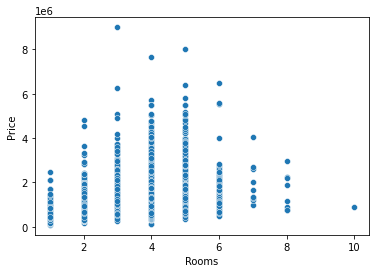

In [42]:
sns.scatterplot(data=df, x='Rooms', y='Price')

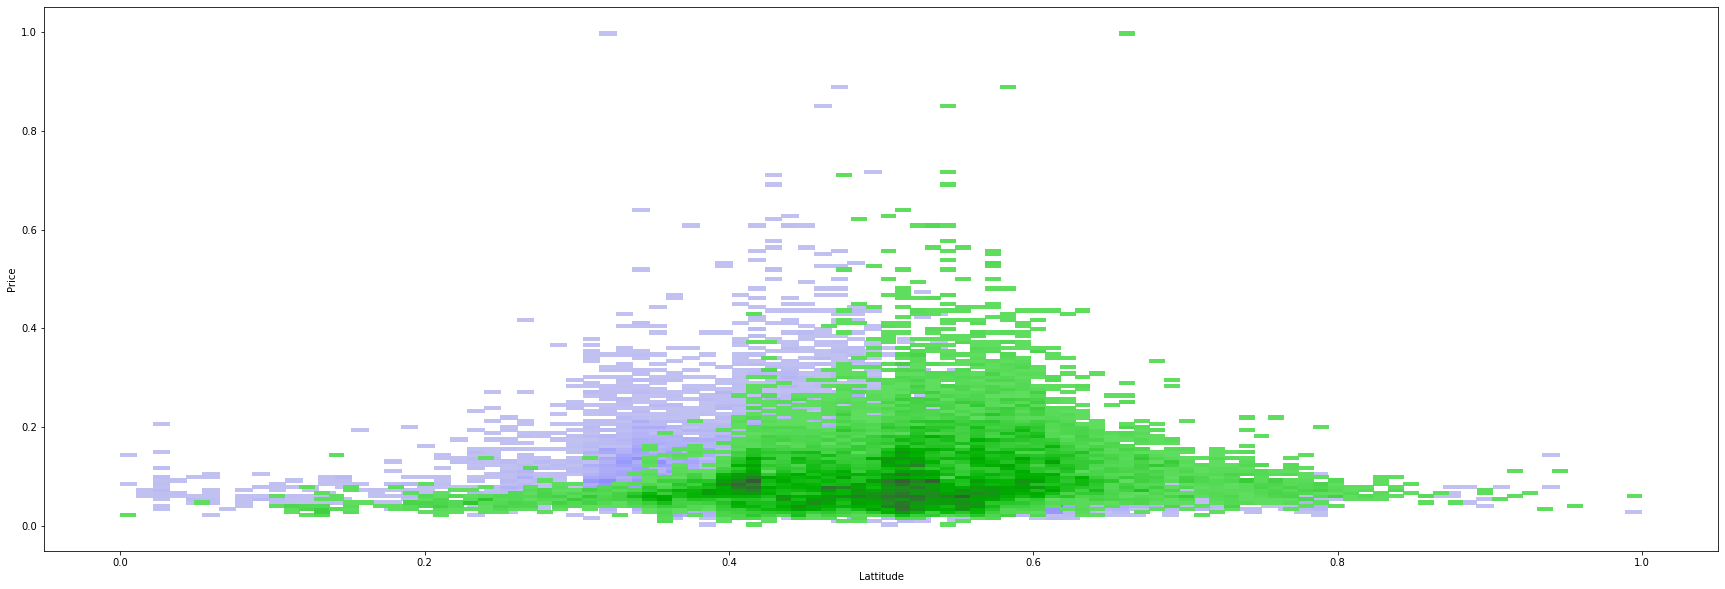

In [43]:
plt.figure(figsize=(30, 10))
df_location = (df - df.min()) / (df.max() - df.min())
sns.histplot(data=df_location, x='Lattitude', y='Price', color='blue')
sns.histplot(data=df_location, x='Longtitude', y='Price', color='green')

## What are we trying to predict?

Plotting what we're trying to predict and it's correlation may help us understand what algorithms deems a better fit to our problem

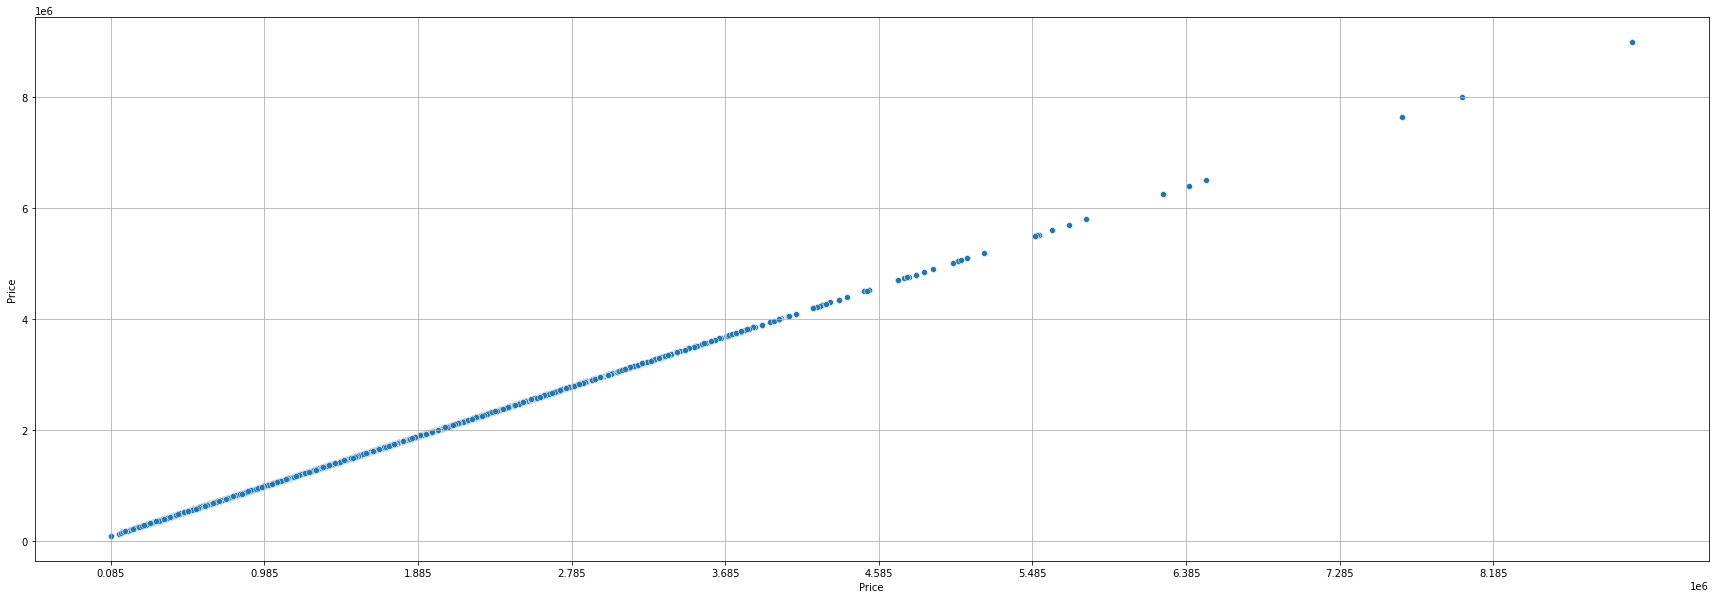

In [44]:
plt.figure(figsize=(30, 10))
plt.xticks(range(ceil(df.Price.min()), ceil(df.Price.max()), ceil(df.Price.max() / 10)))
plt.grid()
sns.scatterplot(data=df, x='Price', y='Price')

It's shape

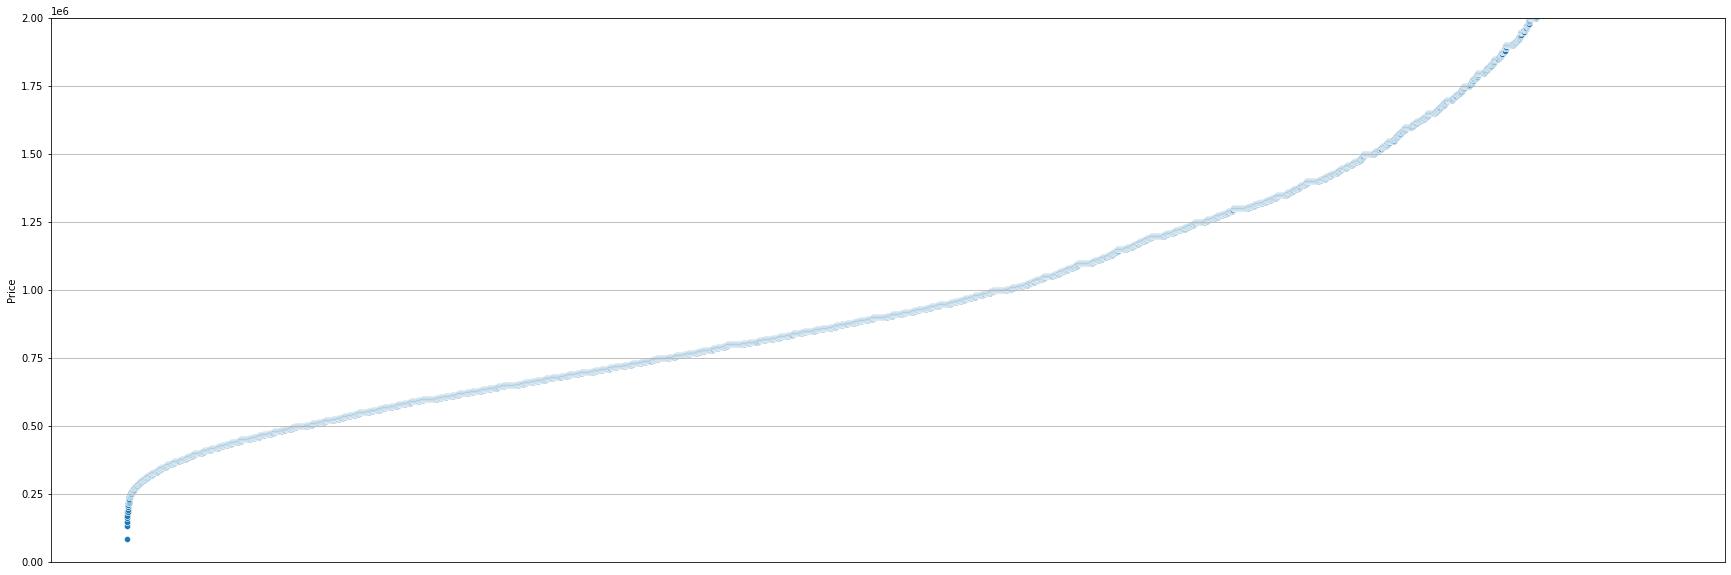

In [45]:
plt.figure(figsize=(30, 10))
df_sorted = df.copy(deep=True).sort_values(by='Price', ascending=True, ignore_index=True)
plt.xticks(range(ceil(df_sorted.Price.min()), ceil(df_sorted.Price.max()), ceil(df_sorted.Price.max() / 10)))
plt.grid()
plt.ylim(0, 2_000_000)
sns.scatterplot(data=df_sorted, x=df_sorted.index, y='Price')

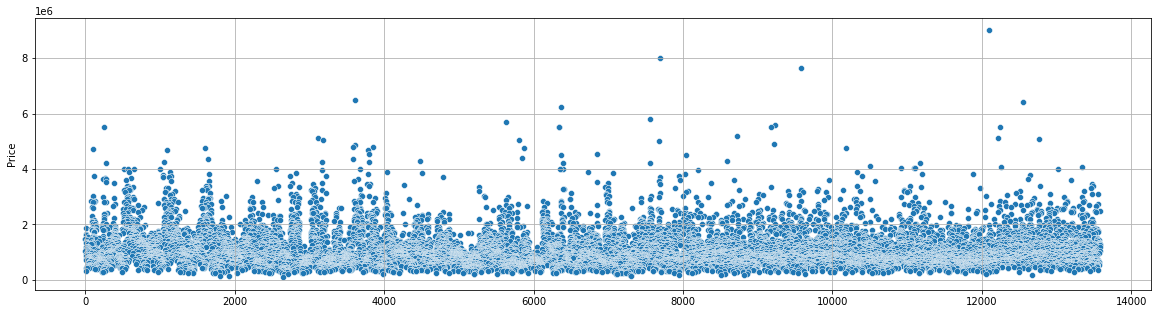

In [46]:
plt.figure(figsize=(20, 5))
df_sorted = df.copy(deep=True).sort_values(by='Price', ascending=False)
# plt.xticks(range(ceil(df_sorted.Price.min()), ceil(df_sorted.Price.max()), ceil(df_sorted.Price.max() / 10)))
plt.grid()
sns.scatterplot(data=df_sorted, x=df_sorted.index, y='Price')

## Sales by day

A quick analysis of the sales pattern over the days in a two year span

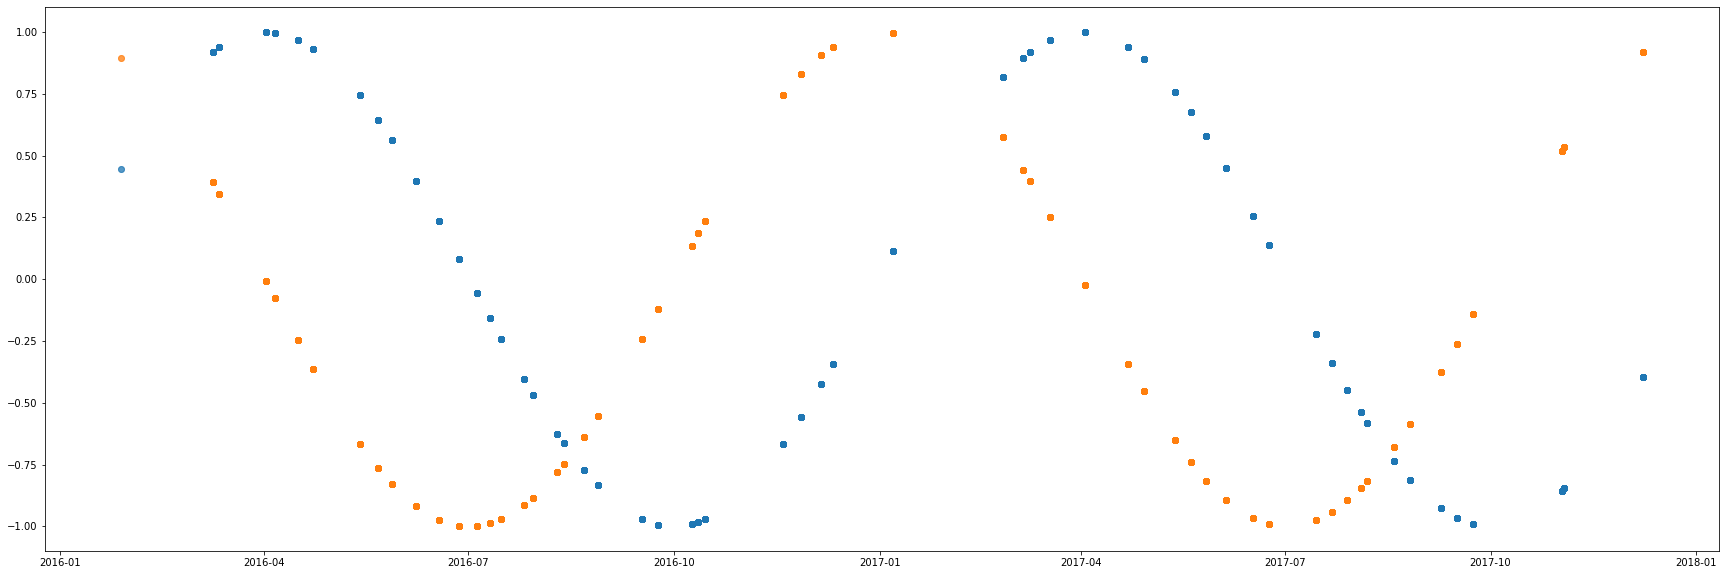

In [47]:
df_date_visualize = df.copy(deep=True)
df_date_visualize.index = date_time

plt.figure(figsize=(30, 10))
plt.scatter(df_date_visualize.index, df_date_visualize['Date_sin'], alpha=.5)
plt.scatter(df_date_visualize.index, df_date_visualize['Date_cos'], alpha=.5)

## Price increase throughout the years

The inflation price increase

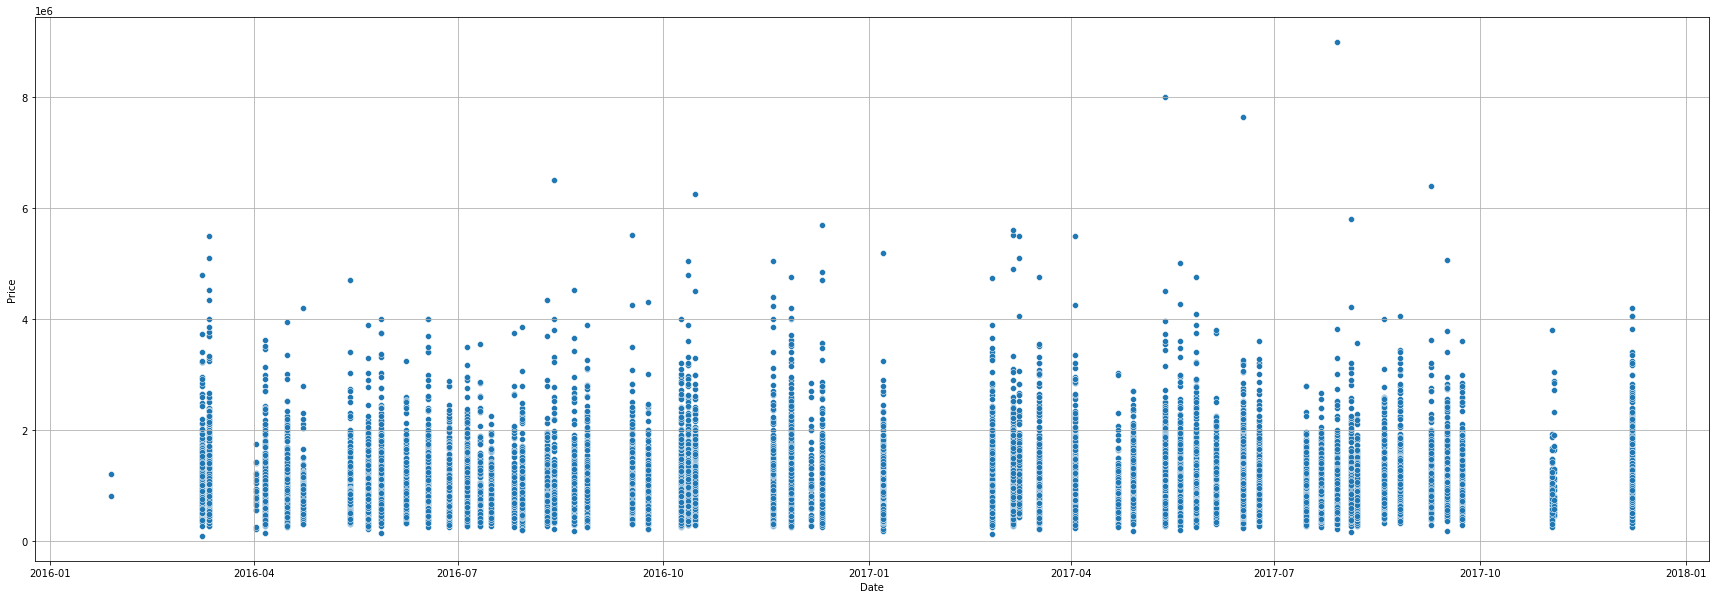

In [48]:
df_inflation = df.copy(deep=True)
df_inflation.index = date_time
plt.figure(figsize=(30, 10))
# sns.lineplot(data=df_inflation, x=df_inflation.index, y='Price')
plt.grid()
# plt.ylim(0, 2_000_000)
sns.scatterplot(data=df_inflation, x=df_inflation.index, y='Price')

## Outliers

Values way too out of the scope, we observed that there were too many outliers

In [49]:
HANDLE_OUTLIERS = False #@param {type: 'boolean'}

In [50]:
if HANDLE_OUTLIERS:
  import scipy

  z_scores = scipy.stats.zscore(df)

  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < 3).all(axis=1)
  df = df[filtered_entries]

Values way above 5_485 are not even worth taking into account, they'll just make the model underperform, they're way too out of scope for a regression to properly adapt to them

## Old houses value

It would make that some really old houses that could even be considered a relic, would be more expensive, or that, in modern times, an older house may be cheaper than a more recent one

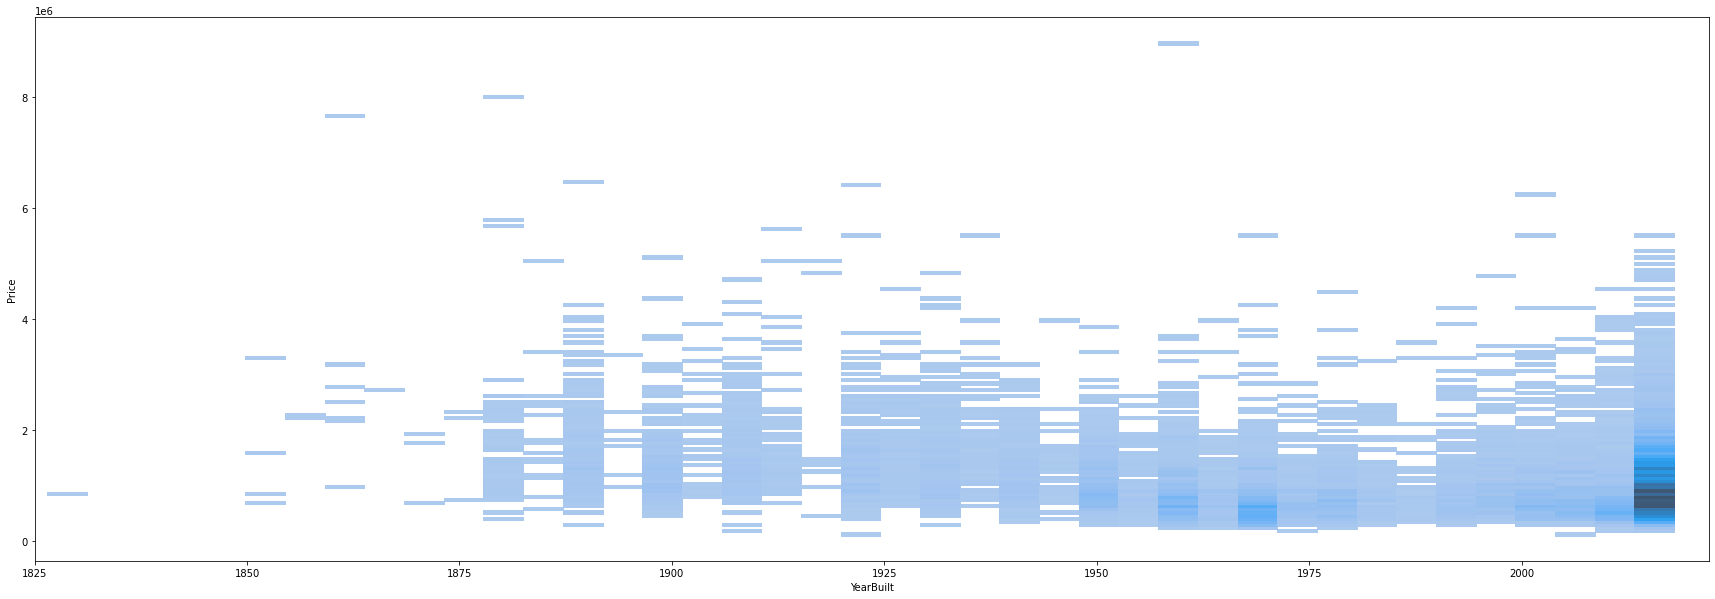

In [52]:
df_old = df.copy(deep=True)
df_old_sorted = df_old.sort_values(by='YearBuilt', ascending=True)
# df_old_sorted = df_old_sorted[ df_old_sorted['YearBuilt'] <= 1_900 ]
# df_old_sorted = df_old_sorted[ df_old_sorted['YearBuilt'] >= 1_900 ]
plt.figure(figsize=(30, 10))
plt.xlim(1_825, 2_022)
sns.histplot(data=df_old_sorted, x='YearBuilt', y='Price')

## Price per square foot

We may be able to get some sort of aproximation, but we have to take into account that, the actual price per square foot should be conscious of different locations, the house features and details I don't know.

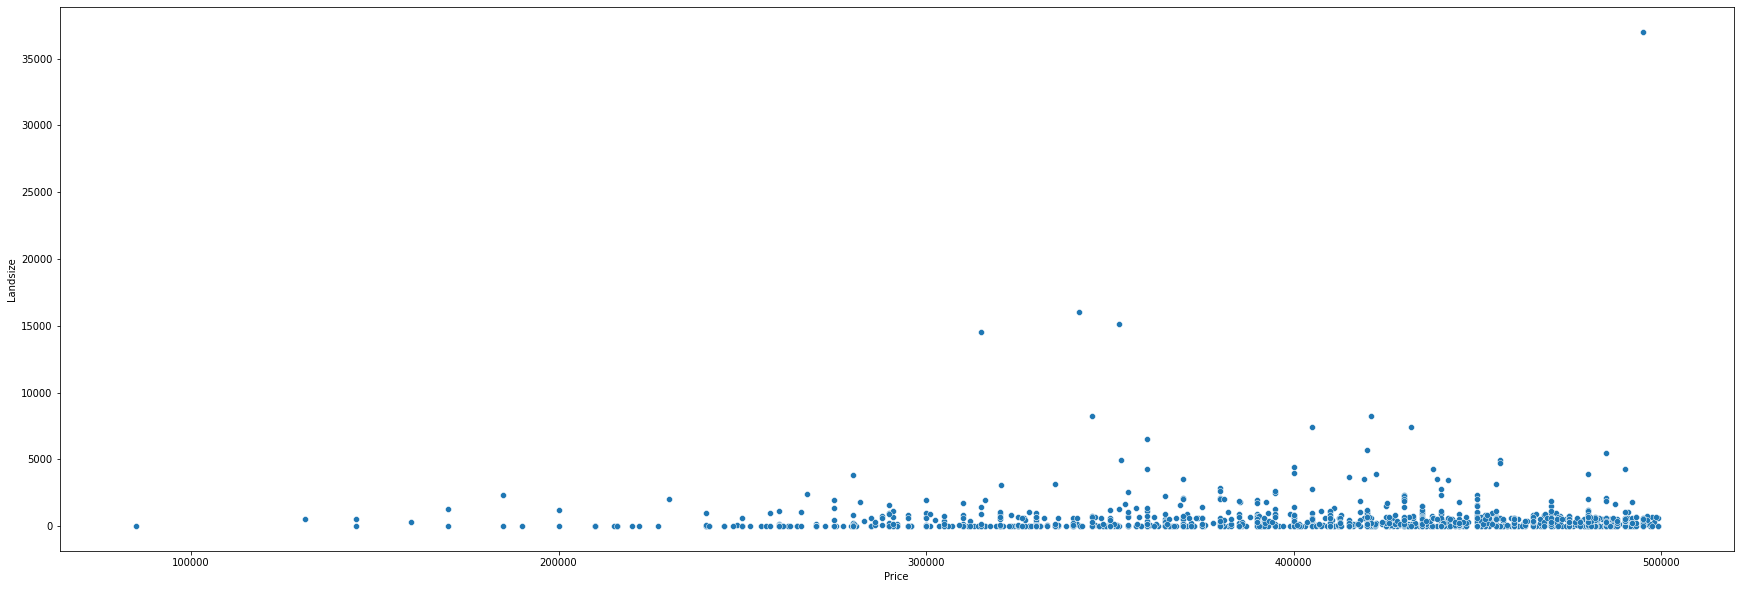

In [114]:
plt.figure(figsize=(30, 10))
sns.scatterplot(data=df[df['Price'] < 500_000], x='Price', y='Landsize')

Increase over time

In [140]:
df_landsize_value = df.copy(deep=True)
# It can't be feature engineered since we can't precisely extract the price per foot beforehand
# so it'd be cheating, but sure, it could actually gives us a better score
df_landsize_value['PricePerFoot'] = (df_landsize_value['Price'] / df_landsize_value['Landsize']).astype('float128')
df_landsize_value['Year'] = date_time.map(lambda x: int(x.year))
df_landsize_value_grouped = df_landsize_value.groupby(by='Year').mean()[ ['PricePerFoot', 'Landsize', 'Price'] ]

I'm doing this just because the number gets crazy high and it returns NaN (because it is, in fact, `inf`)

In [148]:
df_landsize_value_grouped['Price'] / df_landsize_value_grouped['Landsize']

Year
2016    2488.501734
2017    1609.741838
dtype: float64

We may explain a little bit of this number decreasing by simply plotting the year distribution

In [143]:
len(df_landsize_value[ df_landsize_value['Year'] == 2016 ]), len(df_landsize_value[ df_landsize_value['Year'] == 2017 ])

(6336, 7244)

And the mean price of each year

In [146]:
df_landsize_value.groupby(by='Year').mean()[ ['Landsize', 'Price'] ]

,Landsize,Price
Year,,
2016,431.164773,1.072954e+06
2017,669.717145,1.078072e+06


## Location and price

One thing that actually it is well known that does influence the price of the house it's its surroundings, the median value of other houses around, median income of the neighborhood, etc.

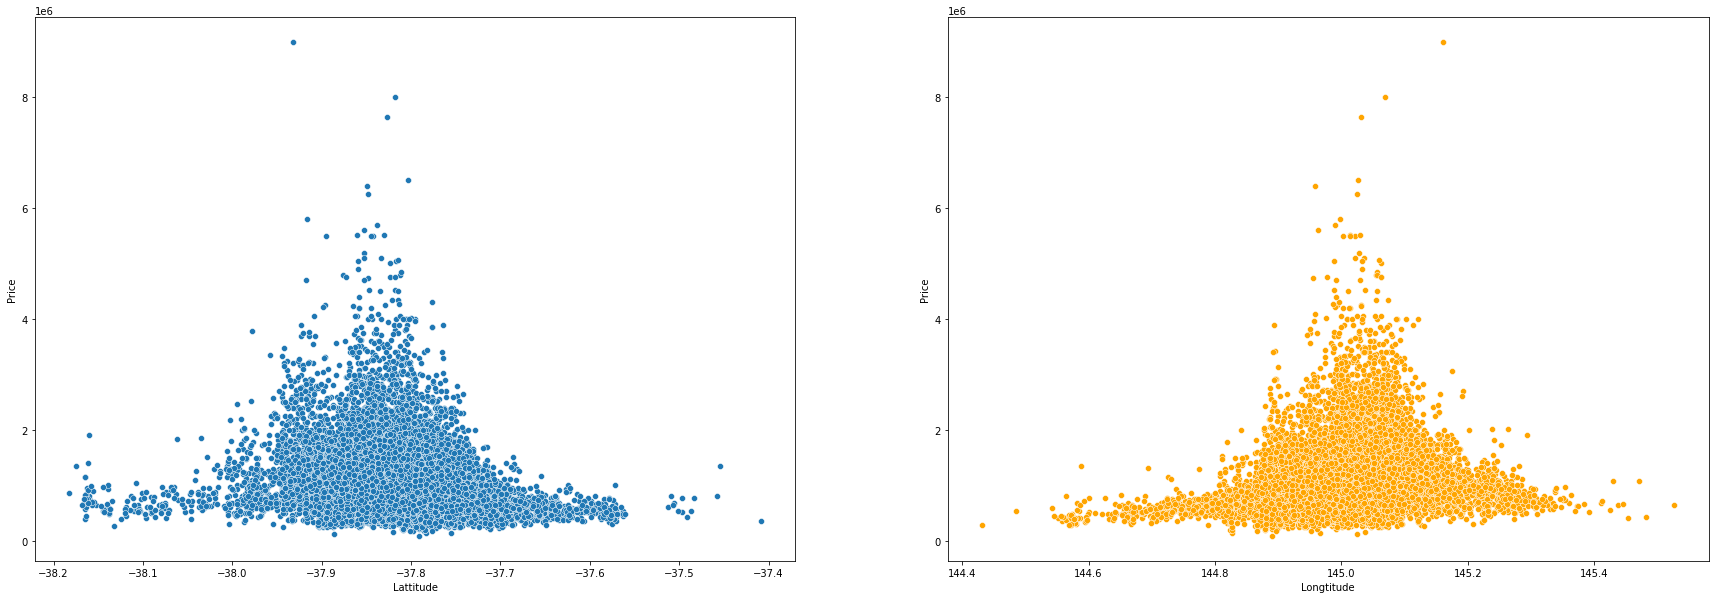

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.scatterplot(data=df, x='Lattitude', y='Price', ax=axes[0])
sns.scatterplot(data=df, x='Longtitude', y='Price', ax=axes[1], color='orange')

# Data Science

Making the final adjustments before jumping straight into the algorithms

## Assignment

In [53]:
target = 'Price'
features = [ col for col in df.columns if col not in [target] ]

We don't really need that high values, they'd just add too much noise, and trying to adjust a line up to those points will miss a lot of the values, not worth it having them

In [54]:
df_train = df.copy(deep=True)

# Values way above the scope
df_train = df_train[ df_train['Price'] <= 5_485_000 ]
# df_train = df_train[ df_train['Price'] <= 4_485_000 ]
# df_train = df_train[ df_train['Price'] <= 2_785_000 ]
# df_train = df_train[ df_train['Price'] <= 2_000_000 ]

# Values way too low for the scope
# df_train = df_train[ df_train['Price'] >= 100_000 ]
df_train = df_train[ df_train['Price'] >= 200_000 ]
# df_train = df_train[ df_train['Price'] >= 250_000 ]

In [55]:
df_train.shape

(13556, 40)

In [56]:
X = df_train[features]
y = df_train[target]

## Splitting

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED)

## Regression plot

In [58]:
from sklearn.linear_model import LinearRegression

def plot_regression(
  model,
  y_true: pd.Series = y_test,
  y_lim_min: float = y_test.min(),
  y_lim_max: float = y_test.max(),
  X_true: pd.DataFrame = X_test
) -> None:
  plt.figure(figsize=(20, 10))
  y_pred = model.predict(X_true)
  plt.scatter(
    y_true,
    y_pred,
    color='blue',
    alpha=0.2,
  )
  # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')

  # squared error
  root_squared_error = r2_score(y_true, y_pred)

  shift = .1
  # shift = 0

  # annotation
  # ann_x, ann_y = (0 + shift, 1 - shift)
  plt.annotate(
    'r-squared = {:.3f}'.format(root_squared_error),
    # (ann_x, ann_y)
    (0, y_lim_max * .95)
  )

  # limit the window view
  plt.ylim(y_lim_min, y_lim_max)

  #regression line
  y_true, y_pred = np.array(y_true).reshape(-1,1), y_pred.reshape(-1,1)
  plt.plot(y_true, LinearRegression().fit(y_true, y_pred).predict(y_true), linewidth=4, color='red')

  # display de plot
  # plt.grid()
  plt.show()

## Comparison utilities

In [59]:
comparison_values = dict()

In [60]:
def evaluate_performance(
  model,
  name: str,
  X_true: np.ndarray = X_test,
  y_true: np.ndarray = y_test,
  score: float = None,
) -> None:
  y_pred = model.predict(X_true)

  # Score
  if score is None:
    score = model.score(X_true, y_true)
    # TODO: implement it also with neural networks, as to have a better comparison
    # so, evaluating the score with r2_score may be a good idea
    print('total score', model.score(X, y)) 
  print('score', score)

  # Mean Absolute Error
  mae = mean_absolute_error(y_true, y_pred)
  print('mae', mae)

  # Mean Absolute Percentage Error
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print('mape', mape)

  comparison_values[name] = { 'name': name, 'algorithm': model, 'score': score, 'mae': mae, 'mape': mape }

# Algorithms

## Imports

In [61]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

## (Polynomial) Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

regr_lin = make_pipeline(
  # PolynomialFeatures(2),
  MinMaxScaler(),
  LinearRegression()
)
regr_lin.fit(X_train, y_train)
evaluate_performance(regr_lin, name='LinearRegression')

total score 0.6268315463434513
score 0.6353204982594967
mae 256859.31796508984
mape 0.2711593959419157


### Evaluation

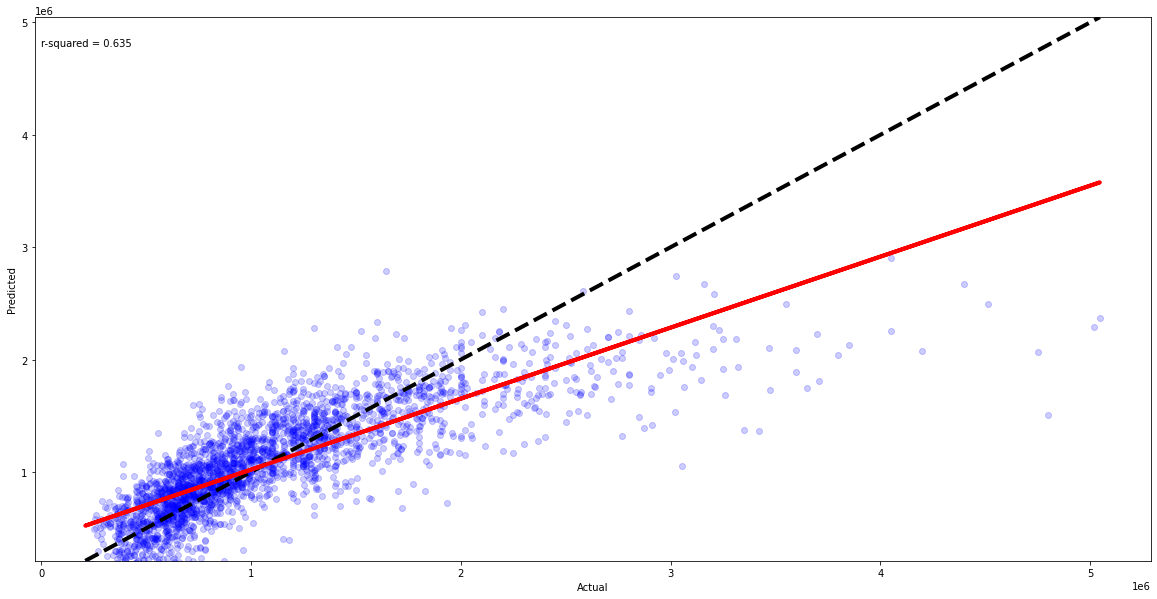

In [63]:
plot_regression(regr_lin)

## XGBoost

In [64]:
from xgboost import XGBRegressor

regr_xgboost = make_pipeline(
  MinMaxScaler(),
  XGBRegressor(
    random_state=RANDOM_SEED,
    objective='reg:squarederror',
    n_estimators=250,
    max_depth=7,
    learning_rate=0.05,
    # learning_rate=0.1,
    # reg_lambda=.75,
    subsample=.8
  )
)
regr_xgboost.fit(X_train, y_train)
evaluate_performance(regr_xgboost, name='XGBRegressor')

total score 0.9436382187495276
score 0.8657394188575298
mae 140865.91411435287
mape 0.12898323378165302


### Hyperparameter tuning

In [65]:
HYPERTUNE_XGBOOST = False #@param {type:'boolean'}

In [66]:
# The last run took 15 minutes and it did not even got the highest of scores
if HYPERTUNE_XGBOOST:
  xgbr_model = XGBRegressor() # {'objective': 'reg:squarederror' }

  params = {
      'n_estimators': [110, 120, 130, 140], 
      'learning_rate': [ 0.05, 0.075, 0.1],
      'max_depth': [ 7, 9 ],
      'reg_lambda': [0.3, 0.5]
  }

  xgb_reg = GridSearchCV(estimator=xgbr_model, param_grid=params, cv=5, n_jobs=-1)

  xgb_reg.fit(X_train, y_train)
  xgbr_model_score = xgb_reg.best_score_
  xgbr_model_pred = xgb_reg.predict(X_test)
  mae = mean_absolute_error(y_test, xgbr_model_pred)

  print("Best score: %0.3f" % xgb_reg.best_score_)
  print("Best parameters set:", xgb_reg.best_params_)

  print("mean_absolute_error :", mae)

### Evaluation

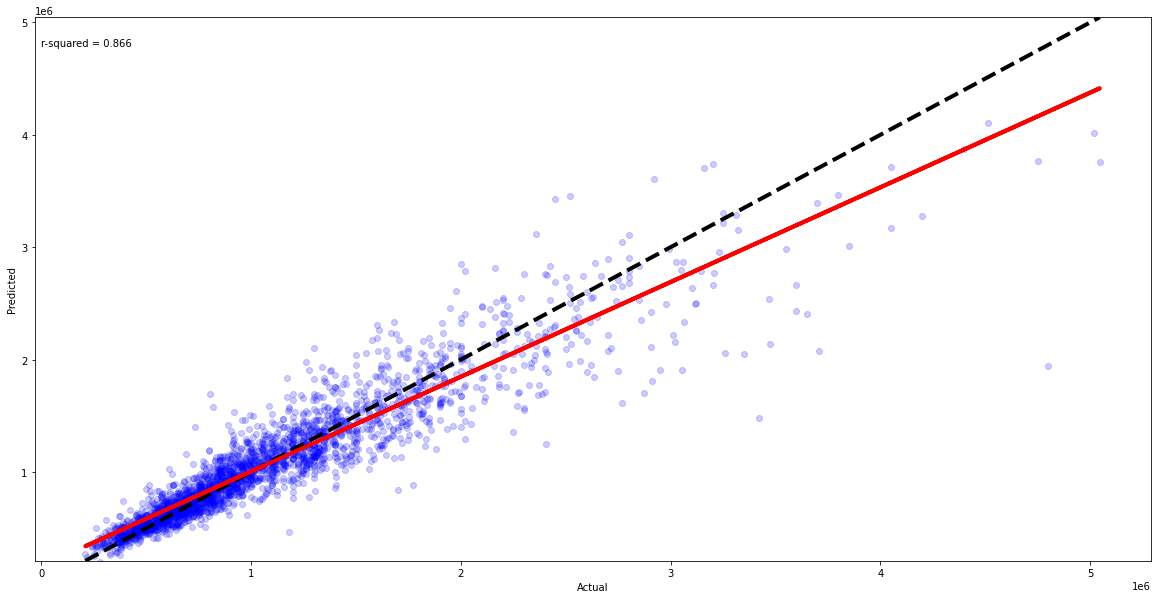

In [67]:
plot_regression(regr_xgboost)

## Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor

regr_rf = make_pipeline(
  MinMaxScaler(),
  RandomForestRegressor(
    random_state=RANDOM_SEED,
    # n_estimators=100,
    # max_depth=10,
  )
)
regr_rf.fit(X_train, y_train)
evaluate_performance(regr_rf, name='RandomForestRegressor')

total score 0.9460623900372127
score 0.8336361836690969
mae 156078.9626364307
mape 0.1425037477281472


### Evaluation

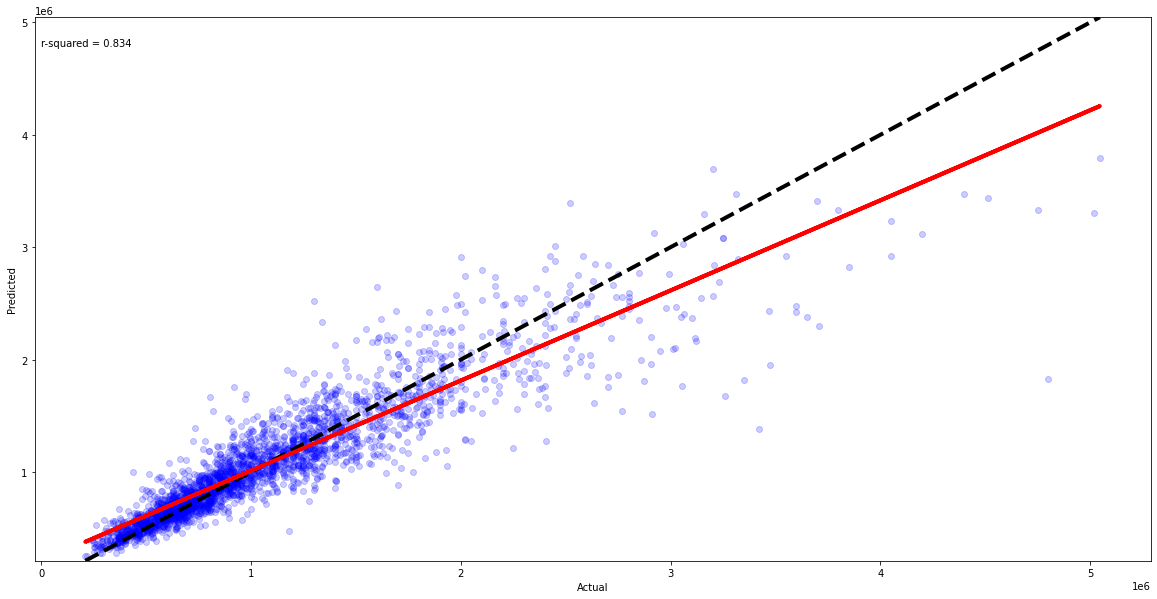

In [69]:
plot_regression(regr_rf)

## Support Vector Machine

In [70]:
# Too slow for a suboptimal performance
if False:
  from sklearn.svm import SVR

  regr_svr = make_pipeline(
    SVR(kernel='linear', C=2.0, epsilon=.3)
  )
  regr_svr.fit(X_train, y_train)
  evaluate_performance(regr_svr, name='Support Vector Machine')

### Evaluation

In [71]:
if False:
  plot_regression(regr_svr)

## Decision Tree

In [72]:
from sklearn.tree import DecisionTreeRegressor
# n_estimators=X_train.shape[1]
regr_tree = make_pipeline(
  MinMaxScaler(),
  DecisionTreeRegressor(random_state=RANDOM_SEED, max_depth=7)
)
regr_tree.fit(X_train, y_train)
evaluate_performance(regr_tree, name='DecisionTreeRegressor')

total score 0.7494729950790777
score 0.7184155364506338
mae 209395.5828262795
mape 0.1948097085201549


### Evaluation

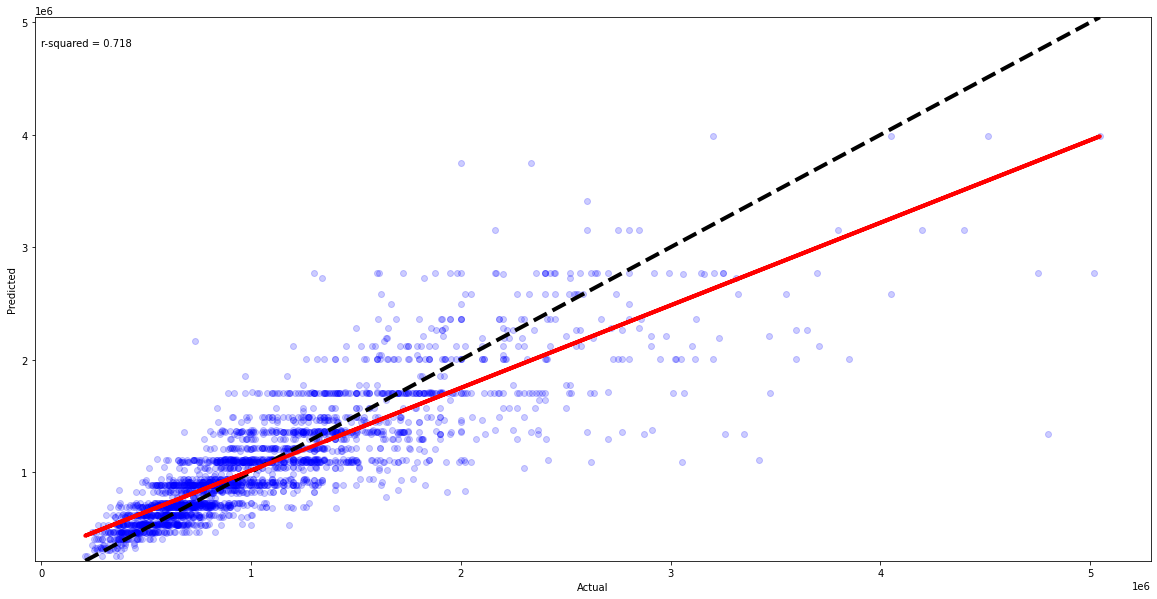

In [73]:
plot_regression(regr_tree)

## Neural network

In [74]:
X_min = X_train.min()
X_max = X_train.max()

X_train_norm = (X_train - X_min) / (X_max - X_min)
X_test_norm = (X_test - X_min) / (X_max - X_min)

In [75]:
y_min = y_train.min()
y_max = y_train.max()

y_train_norm = (y_train - y_min) / (y_max - y_min)
y_test_norm = (y_test - y_min) / (y_max - y_min)

In [76]:
import tensorflow as tf

dense_model = tf.keras.Sequential(
  name='Melbourne-Housing-Estimator',
  layers=[
    tf.keras.layers.Dense(units=X_train_norm.shape[1], input_dim=X_train_norm.shape[1], name='Input-Layer'),
    tf.keras.layers.Dense(
      units=32, name='Hidden-Layer',
      # kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
      # bias_regularizer=tf.keras.regularizers.L2(1e-4),
      # activity_regularizer=tf.keras.regularizers.L2(1e-5),
    ),
    tf.keras.layers.Dense(
      units=16, name='Second-Hidden-Layer',
      # kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
      # bias_regularizer=tf.keras.regularizers.L2(1e-4),
      # activity_regularizer=tf.keras.regularizers.L2(1e-5),
    ),
    tf.keras.layers.Dense(units=1, activation='linear', name='Output-Layer'),
  ],
)

dense_model.compile(
  loss=tf.losses.mae,
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  metrics=[tf.metrics.mae, tf.metrics.mse],
)

dense_model.summary()

Model: "Melbourne-Housing-Estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 39)                1560      
                                                                 
 Hidden-Layer (Dense)        (None, 32)                1280      
                                                                 
 Second-Hidden-Layer (Dense)  (None, 16)               528       
                                                                 
 Output-Layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 3,385
Trainable params: 3,385
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = dense_model.fit(
  X_train_norm,
  y_train_norm,
  validation_split=.1,
  epochs=100,
  # use_multiprocessing=True,
  # workers=cpu_count() - 1,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3)
  ],
  verbose=0,
)

In [78]:
dense_model.evaluate(X_test_norm, y_test_norm)
tf_score = r2_score(y_test_norm, dense_model.predict(X_test_norm))
print('score', tf_score)
# tf_mae = mean_absolute_error(y_test_norm, dense_model.predict(X_test_norm))
# print('mae', (tf_mae + y_min) * (y_max - y_min))
print('mae', mean_absolute_error(y_test_norm, dense_model.predict(X_test_norm)))
print('mape', mean_absolute_percentage_error(y_test, regr_tree.predict(X_test)))

85/85 [==============================] - 0s 1ms/step - loss: 0.0550 - mean_absolute_error: 0.0550 - mean_squared_error: 0.0073
score 0.5173504836925733
mae 0.05499275017062514
mape 0.1948097085201549


In [79]:
evaluate_performance(dense_model, name='Dense Neural Network', score=tf_score)

score 0.5173504836925733
mae 1075725.2352940403
mape 0.9997320741935067


### Evaluation

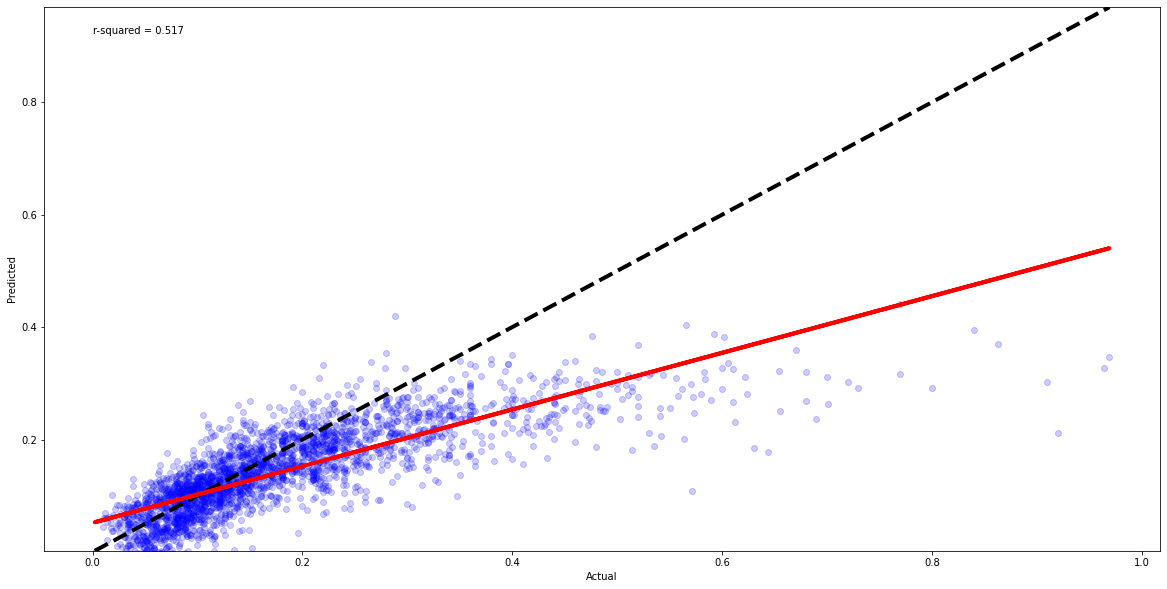

In [80]:
plot_regression(dense_model, X_true=X_test_norm, y_true=y_test_norm, y_lim_min=y_test_norm.min(), y_lim_max=y_test_norm.max())

## LightGBM

In [81]:
from lightgbm import LGBMRegressor

regr_lgbm = make_pipeline(
  MinMaxScaler(),
  LGBMRegressor(
    random_state=RANDOM_SEED,
    n_estimators=250,
    max_depth=7,
    learning_rate=0.05
  )
)
regr_lgbm.fit(X_train, y_train)
evaluate_performance(regr_lgbm, name='LGBMRegressor')

total score 0.9070979815310993
score 0.8585156140892934
mae 146322.2535179827
mape 0.1352285379311356


### Evaluation

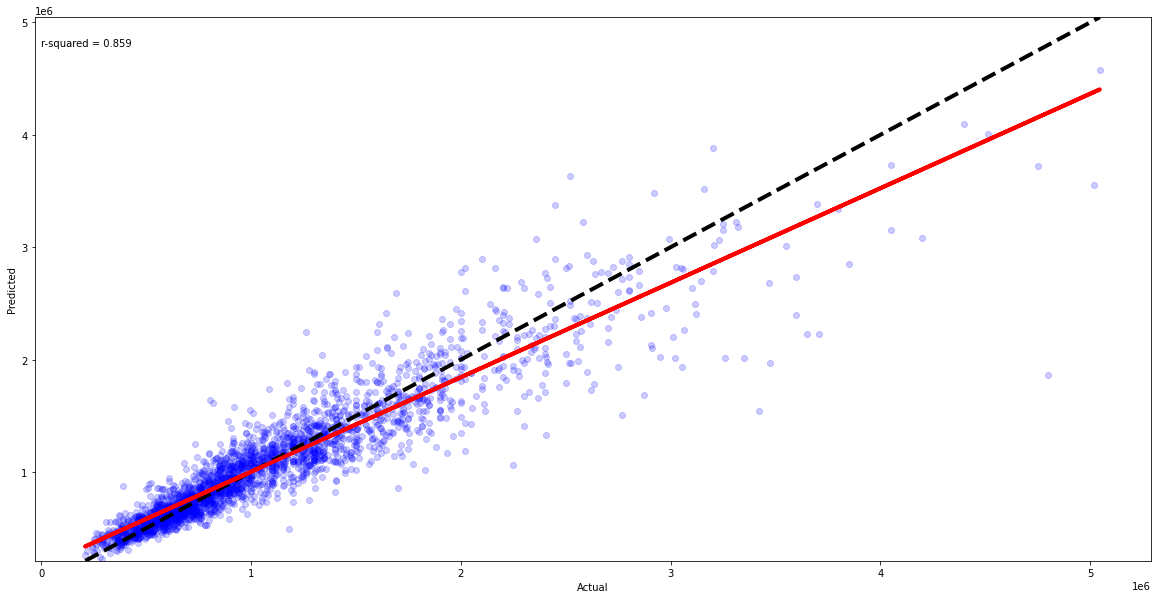

In [82]:
plot_regression(regr_lgbm)

## Bayes

In [83]:
from sklearn.linear_model import BayesianRidge

regr_bayes = make_pipeline(
  MinMaxScaler(),
  BayesianRidge()
)
regr_bayes.fit(X_train, y_train)
evaluate_performance(regr_bayes, name='BayesianRidge')

total score 0.6266887335327285
score 0.6349925450146034
mae 256900.33753093198
mape 0.27114155866613143


### Evaluation

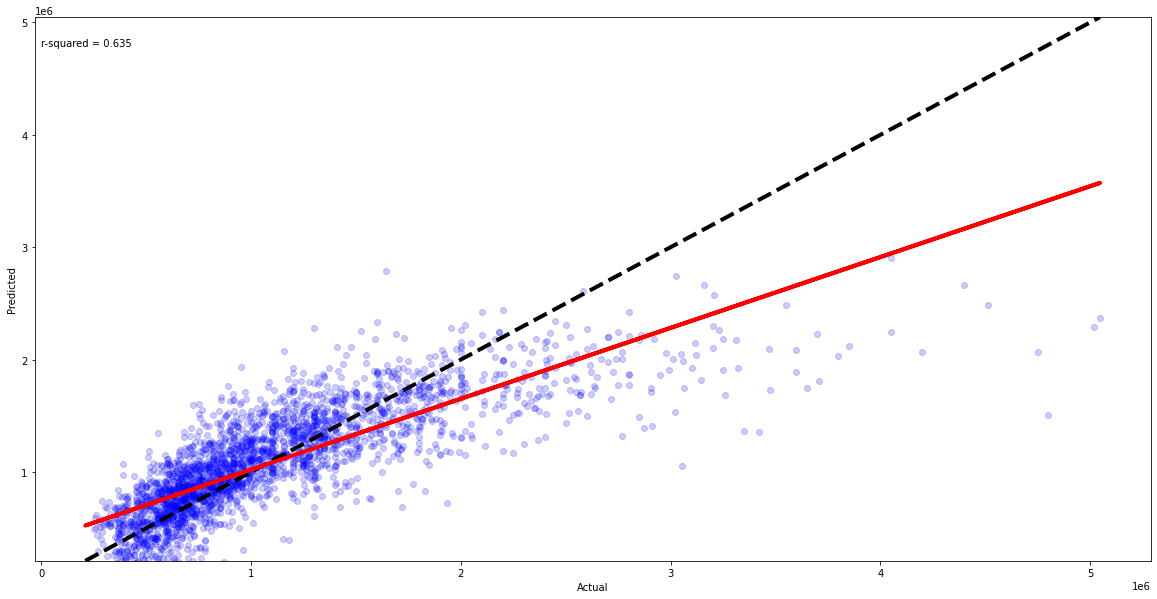

In [84]:
plot_regression(regr_bayes)

## Lasso

In [85]:
from sklearn.linear_model import Lasso

regr_lasso = make_pipeline(
  MinMaxScaler(),
  Lasso(
    max_iter=3_000,
  )
)
regr_lasso.fit(X_train, y_train)
evaluate_performance(regr_bayes, name='BayesianRidge')

total score 0.6266887335327285
score 0.6349925450146034
mae 256900.33753093198
mape 0.27114155866613143


### Evaluation

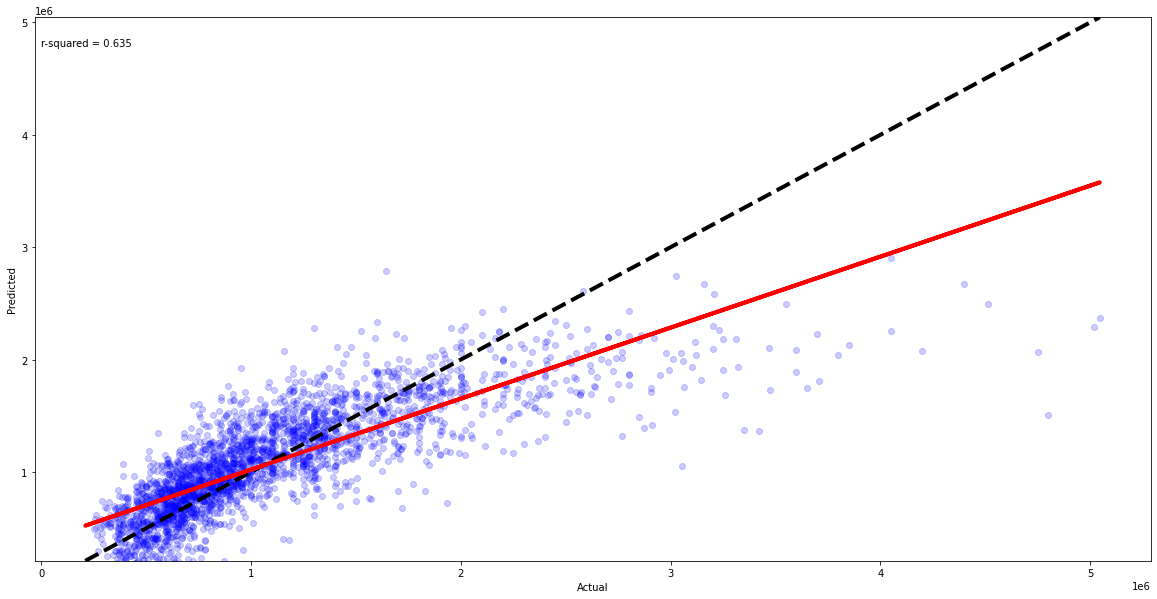

In [86]:
plot_regression(regr_lasso)

## Single-shot

In [87]:
import tensorflow as tf

single_shot_model = tf.keras.Sequential(
  name='Single-shot-Melbourne-Housing-Estimator',
  layers=[
    tf.keras.layers.Dense(units=X_train_norm.shape[1], input_dim=X_train_norm.shape[1], name='Input-Layer'),
    tf.keras.layers.Dense(units=1, activation='linear', name='Output-Layer'),
  ],
)

single_shot_model.compile(
  loss=tf.losses.mae,
  optimizer=tf.optimizers.Adam(),
  metrics=[tf.metrics.mae, tf.metrics.mse],
)

single_shot_model.summary()

Model: "Single-shot-Melbourne-Housing-Estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 39)                1560      
                                                                 
 Output-Layer (Dense)        (None, 1)                 40        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = single_shot_model.fit(
  X_train_norm,
  y_train_norm,
  validation_split=.1,
  epochs=100,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3)
  ],
  verbose=0,
)

In [89]:
single_shot_model.evaluate(X_test_norm, y_test_norm)
tf_score = r2_score(y_test_norm, single_shot_model.predict(X_test_norm))
print('score', tf_score)
print('mae', mean_absolute_error(y_test_norm, single_shot_model.predict(X_test_norm)))
print('mape', mean_absolute_percentage_error(y_test, regr_tree.predict(X_test)))

85/85 [==============================] - 0s 1ms/step - loss: 0.0531 - mean_absolute_error: 0.0531 - mean_squared_error: 0.0067
score 0.5572204662347633
mae 0.053080290174897966
mape 0.1948097085201549


In [90]:
evaluate_performance(single_shot_model, name='SingleShot', score=tf_score)

score 0.5572204662347633
mae 1075588.5222986685
mape 0.9995914206951299


### Evaluation

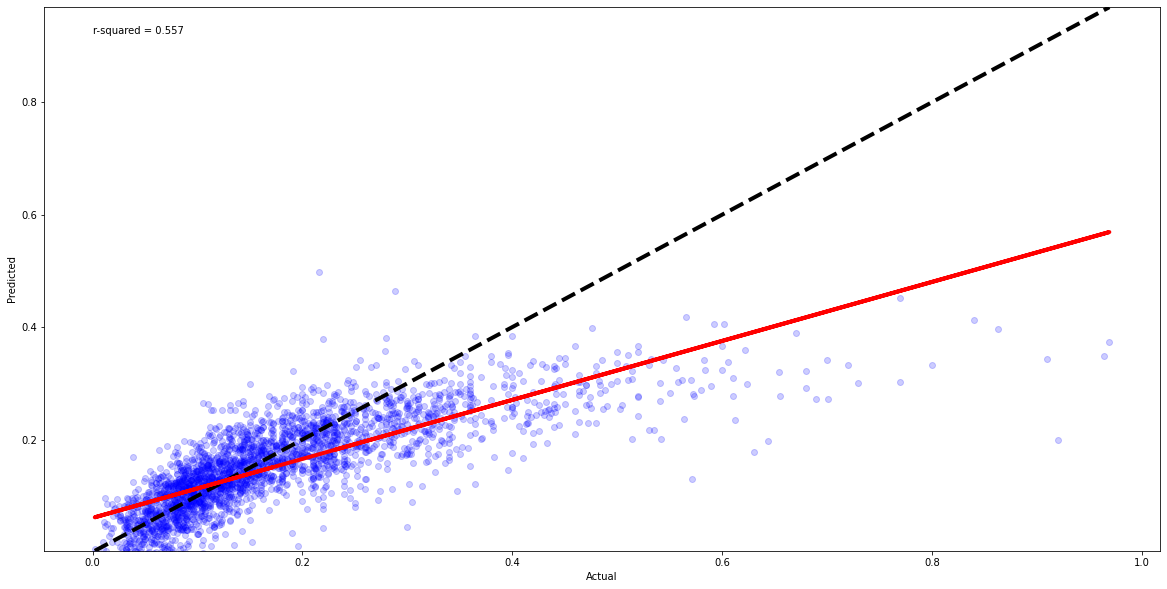

In [91]:
plot_regression(single_shot_model, X_true=X_test_norm, y_true=y_test_norm, y_lim_min=y_test_norm.min(), y_lim_max=y_test_norm.max())

# Evaluation

It is now time to actually conclude how well did it adapt to what we were looking for

## Prediction vs Actual values

In [93]:
# EVALUATION_PLOT_STEPS = 20 #@param {type:'integer'}
EVALUATION_PLOT_STEPS = 25 #@param {type:'integer'}

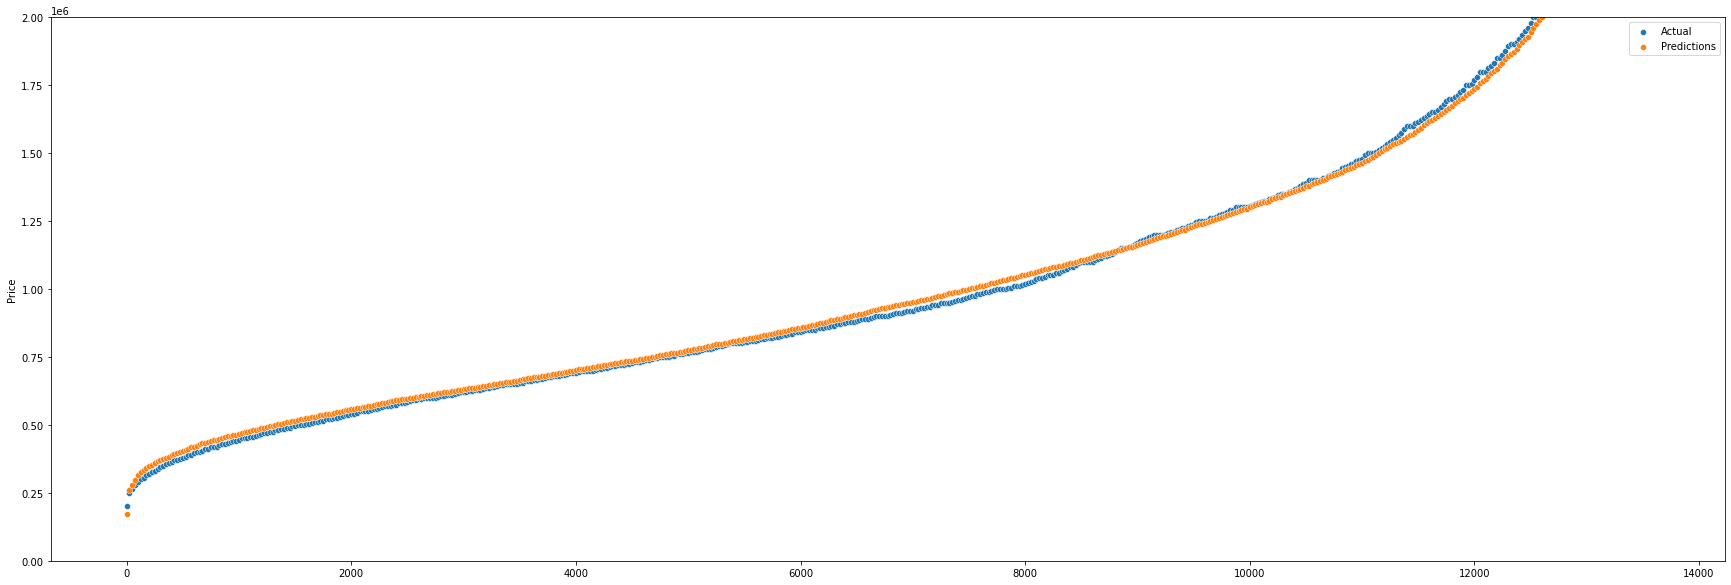

In [100]:
plt.figure(figsize=(30, 10))
plt.ylim(0, 2_000_000)
# plt.ylim(2_000_000, 5_485_000)

original = y.sort_values(ignore_index=True)[::EVALUATION_PLOT_STEPS]
# original.index = range(0, len(original))
sns.scatterplot(data=original, x=original.index, y=original, label='Actual')

pred = pd.Series(regr_xgboost.predict(X)).sort_values(ignore_index=True)[::EVALUATION_PLOT_STEPS]
sns.scatterplot(data=pred, x=pred.index, y=pred, label='Predictions')

# Conclusions

In [95]:
df_comparison = pd.DataFrame(comparison_values.values()).sort_values(
  # by='score', ascending=False
  by='score',
  # by='mae',
  # by='mape',
  ascending=False,
)
df_comparison = df_comparison.drop(columns=['algorithm'])

In [96]:
df_comparison

,name,score,mae,mape
1,XGBRegressor,0.865739,1.408659e+05,0.128983
5,LGBMRegressor,0.858516,1.463223e+05,0.135229
2,RandomForestRegressor,0.833636,1.560790e+05,0.142504
3,DecisionTreeRegressor,0.718416,2.093956e+05,0.194810
0,LinearRegression,0.635320,2.568593e+05,0.271159
6,BayesianRidge,0.634993,2.569003e+05,0.271142
7,SingleShot,0.557220,1.075589e+06,0.999591
4,Dense Neural Network,0.517350,1.075725e+06,0.999732


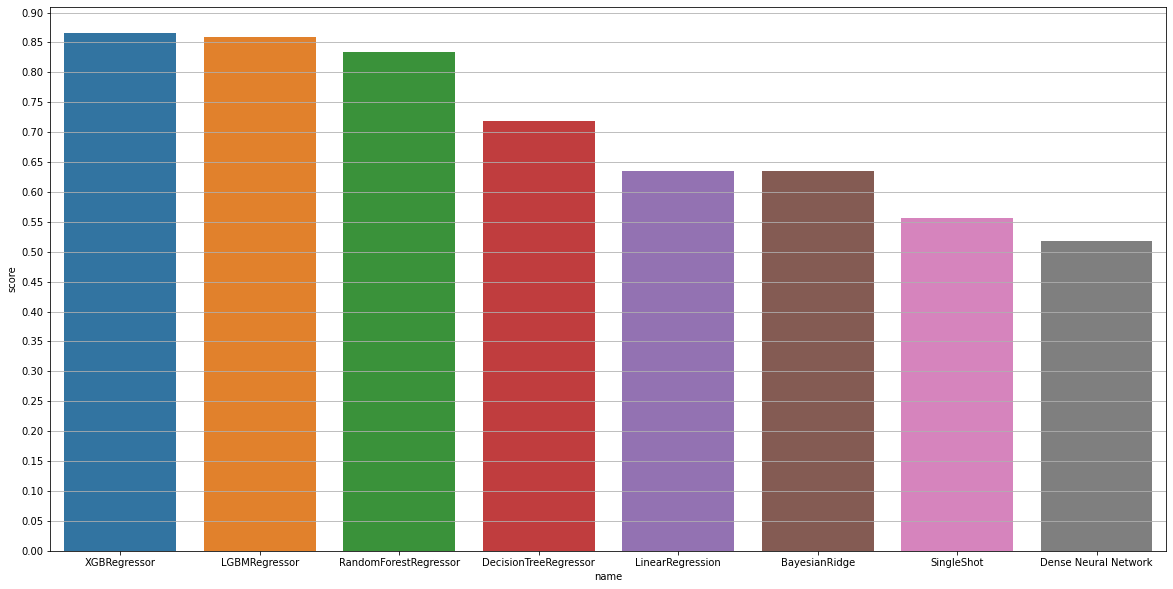

In [97]:
plt.figure(figsize=(20, 10))
plt.yticks(np.array(range(0, 100, 5)) / 100)
plt.grid()
sns.barplot(
  data=df_comparison,
  x='name',
  y='score'
  # y='mae',
  # y='mape',
)

# Credits

- https://www.kaggle.com/code/vikasukani/melbourne-house-price-predic-using-ml-model